#### Simulation with the prediction block using persistence of the previous instant

#### $\hspace{15px}$ $\tilde{X}(k) = X(k-1)$, 
#### $\hspace{15px}$ $\tilde{Y}(k) = Y(k-1)$, 


Maximum voltage rise $vm_{pu}^{max} = 1.0250$

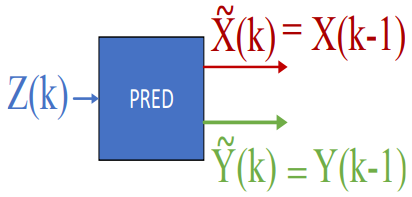

---

#### Import Modules 


In [2]:
import pandas as pd
import pandapower as pp
import matplotlib.pyplot as plt
import numpy as np
import ipyparallel as ipp
from tqdm import tqdm # Profiling 
import pickle, sys, importlib,  time
import os
from pickle import load
import joblib

In [15]:
# import psutil
function_folder = '../Modules/' 
# Add function folder to path if it is not already
if function_folder not in sys.path: sys.path.append(function_folder)

import oriFunctions as oriFc
import oriClass as oriCs
from oriVariables import (simResult_folder,
                          Δt,
                          pd_Δt,
                          ctrld_HvProd_name,
                          h_start_end, 
                          hm10_start_end,
                          default_hv_voltage,
                          defAuth_hvBus_vRiseMax, 
                          defAuth_hvBus_vRiseMin, 
                          modules_folder, 
                          valSet_start_M2, 
                          testSet_end_M1, 
                          lowerNet_file_loc, 
                          upperNet_file_loc,
                          cleanedData_name) 

import checker

#### Import data Cleaned file for network's input

In [9]:
df_data = joblib.load(f'{simResult_folder}{cleanedData_name}')

# Extract only dailight period i.e. from 07am to 7PM
# The daylight period is considered to be defined betwenn 07am and 7Pm excluded. 
per_index = df_data.index
per_daylight = ( pd.Series(index=per_index.to_timestamp(), dtype=object).between_time(*hm10_start_end) ).index.to_period(pd_Δt)
day_tot_per = len(per_daylight[(per_daylight.year==df_data.index.year[0])
                               &(per_daylight.month==1)
                               &(per_daylight.day==1)])


# Put all the data in a unique dataframe
df_data = df_data.loc[per_daylight]

# # Extract only the relavant testing set since the training set covers the first part of the data
df_final = df_data[(df_data.index>=valSet_start_M2) & (df_data.index<=testSet_end_M1)]
per_index = df_final.index
per_index2 = ( pd.Series(index=per_index.to_timestamp(), dtype=object
                           ).between_time(*h_start_end) ).index.to_period(pd_Δt)

df_final_copy = df_final.copy(deep=True)

# Check wether the input dataframe columns are in the expected order
checker.check_networkDataDf_columnsOrder(df_final)


# If df_final is in the expected form we can collect the data as follow
df_cons_total = df_final.iloc[:,[0]]
df_prod_bt_total = df_final.iloc[:,[1]]
df_prodHT = df_final.iloc[:,2:]

#### Import Networks


In [17]:
lowerNet=pp.from_pickle(lowerNet_file_loc)
upperNet=pp.pp.from_pickle(upperNet_file_loc)

# Init an object of the class InitNetworks
networks = oriCs.InitNetworks(upperNet, lowerNet)


#### Operation on network parameters

In [18]:
# Defined Voltage rise threshold
vm_mu_max, vm_mu_min = defAuth_hvBus_vRiseMax, defAuth_hvBus_vRiseMin  

# Inititialize the controllable hv prod in the network
networks.init_controlled_hvProd(ctrld_HvProd_name)

# Extract the HV bus from the list of activated bus 
lowerNet_hv_activated_bus = networks.get_lowerNet_hvActivatedBuses(lowerNet
                                                                   .bus
                                                                   .query('vn_kv==@default_hv_voltage').index)
# Add maximum voltage constraints on the Hv Buses in the network 
networks.lowerNet_set_vrise_threshold(lowerNet_hv_activated_bus, vm_mu_min, vm_mu_max)

### Controllable Generators costs

In [19]:
# get the index of the controlled HV prod in SGEN table
ctrld_hvProd_index = lowerNet.sgen.query('name==@ctrld_HvProd_name').index

# Add negative cost to usability of sgen P0100 so its usage can be maximised while respecting the constraints on the network
pp.create_poly_cost(lowerNet, ctrld_hvProd_index,'sgen', cp1_eur_per_mw=-1)

lowerNet.poly_cost

,element,et,cp0_eur,cp1_eur_per_mw,cp2_eur_per_mw2,cq0_eur,cq1_eur_per_mvar,cq2_eur_per_mvar2
0,23,sgen,0.0,-1.0,0.0,0.0,0.0,0.0


#### Start Parallel engines

In [21]:
n_engines = os.cpu_count()-1         # Total number of engines
parEngines = oriCs.CreateParEngines(n_engines)

Starting 7 engines with <class 'ipyparallel.cluster.launcher.LocalEngineSetLauncher'>


  0%|          | 0/7 [00:00<?, ?engine/s]

#### Data extraction from the network

## OPF Persistence Model 

#### Define Data to use in local space of engines

In [31]:
# Parameters for the persistence model
opf_status = 'Both' 
pred_model = 'Pers'

parameters_dict = dict({'lowerNet':lowerNet, 
                        'lowerNet_hv_activated_bus':lowerNet_hv_activated_bus, 
                        'sum_max_main_network':networks.get_upperNet_sum_max_lvProdLoad(), 
                        'vm_mu_max':vm_mu_max, 
                        'pred_model': pred_model
                       })

# Initialize variables for parallel engines
dict_df_sgenLoad = oriFc.createDict_prodHtBt_Load(df_final,
                                                  networks )

#### Send data into local space of each engine

In [32]:
df_prodHT_index = dict_df_sgenLoad['df_prodHT'].index # Extract index of periods the parallel 
                                                      # engines must work with.
        
# Send all the created variables into local spaces of each engine.
parEngines.sendVar_to_localSpace(df_prodHT_index, 
                                 opf_status, 
                                 dict_df_sgenLoad, 
                                 parameters_dict, 
                                 clean=True )

importing numpy on engine(s)
importing pandapower on engine(s)
importing pandas on engine(s)
importing sys on engine(s)
importing oriFunctions on engine(s)


#### Run Optimal Power flow  in each local engine
**<span style='color:red'> -----------------  BLOC  PF/OPF -------------------  </span>**

In [33]:
%%px 
resulting = [oriFunctions.run_powerflow_at(lowerNet, 
                                           cur_period+1, 
                                           lowerNet_hv_activated_bus, 
                                           sum_max_main_network, 
                                           dict_df_sgenLoad, 
                                           vm_mu_max, 
                                           opf_status, 
                                           pred_model) 
             for cur_period in period_part]

%px:   0%|          | 0/7 [00:00<?, ?tasks/s]

 <span style='color:red'> **-------------------------------------------------------**  </span>

#### Extract results

In [79]:
# Gather the result of each engine in a single list
results = parEngines.gather_results('resulting')
time.sleep(1)

# Extract results
extracted_results = parEngines.get_results_asDf()

# # Get maximum volatage over the network 
max_vm_pu_df_pers = extracted_results[['max_vm_pu']]

### Reality check

**<span style='color:red'> -------------------  BLOC PROD  ---------------------</span>**

In [80]:
oriFc.block_prod(extracted_results, 
                 df_final[[ctrld_HvProd_name]] )

 <span style='color:red'> **-------------------------------------------------------**  </span>

#### Update Values for the dicts to use for power flow


In [127]:
# Get the non controllable HV prod names
non_ctrld_HvProd_names_list = oriFc.get_nonCtrld_HvProd_names(df_final.columns[2:],
                                                              ctrld_HvProd_name ) 
# Update Values of the dataframe to use for final power flow bloc with Interest variables 
# (Real load, real Prod of LV Prod, and Non-COntroled HV Prod, Injected power of Ctrl Prod
df_final2 =pd.concat([df_final.loc[per_index2].iloc[:,[0,1]],
                      df_final.loc[per_index2, non_ctrld_HvProd_names_list],
                      extracted_results.loc[per_index2, [ctrld_HvProd_name]],
                     ], axis='columns')

# Check df_final2 columns order
checker.check_networkDataDf_columnsOrder(df_final2)    

# Creat dict to send to par Engines based
dict_df_sgenLoad = oriFc.createDict_prodHtBt_Load(df_final2,
                                                  networks )

opf_status = False 
df_prodHT_index = dict_df_sgenLoad['df_prodHT'].index # Extract  index of periods.

#### Send data into local space of each engine

In [128]:
parEngines.sendVar_to_localSpace(df_prodHT_index, 
                                 opf_status, 
                                 dict_df_sgenLoad, 
                                 parameters_dict, 
                                 clean=False )

#### Run power flow in each local engine
**<span style='color:red'> ------------------------ BLOC  PF  -----------------------  </span>**

In [130]:
%%px 
resulting = [oriFunctions.run_powerflow_at(lowerNet, cur_period, 
                                           lowerNet_hv_activated_bus, 
                                           sum_max_main_network,
                                           dict_df_sgenLoad, 
                                           vm_mu_max, 
                                           opf_status) 
             for cur_period in period_part]

%px:   0%|          | 0/7 [00:00<?, ?tasks/s]

 <span style='color:red'> **-------------------------------------------------------**  </span>

#### Extract results

In [197]:
# Gather the result of each engine in a single list
results_pf_per = parEngines.gather_results('resulting')
# time.sleep(1)

# get Result as a dataframe
max_vm_pu_per_df = parEngines.get_results_asDf()

#### Plot created Dataframe

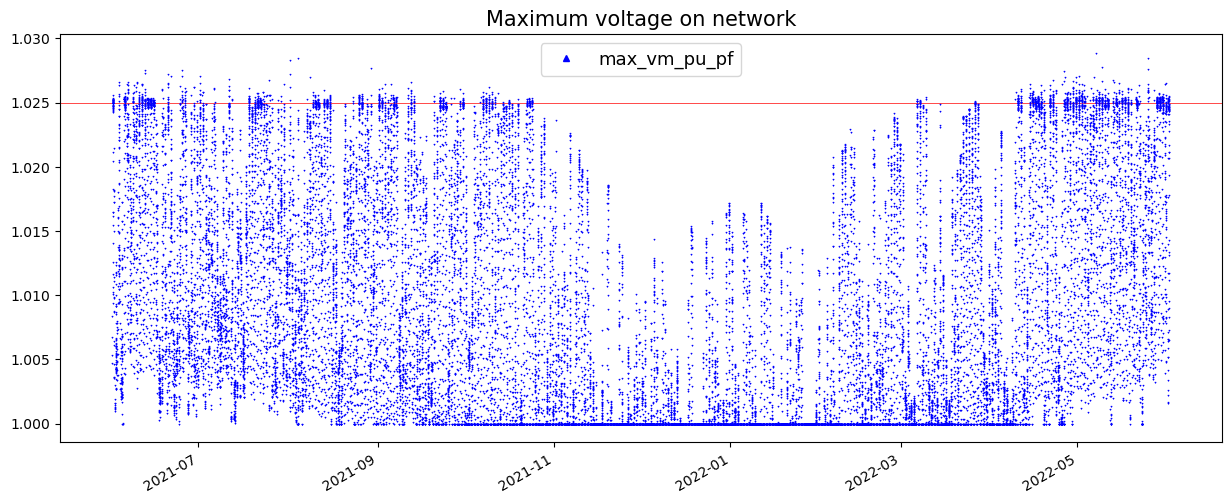

In [198]:
fig, axx = plt.subplots(figsize=(15,6), dpi=100)
plt.axhline(vm_mu_max,color='r', lw=0.5)

max_vm_pu_per_df.plot(style = ['b^'],markersize=0.5, ax=axx)
plt.legend( fontsize=13, markerscale=10)
plt.title("Maximum voltage on network", fontsize=15);

#### Setting up variables

In [199]:
ctrld_HvProd_df = df_final.loc[per_index2, [ctrld_HvProd_name]]
ctrld_HvProd_pers_df = pd.DataFrame(data=extracted_results.loc[per_index2, ctrld_HvProd_name].values, 
                             index=extracted_results.loc[per_index2].index, 
                             columns=['Pers'] )
# Concat
ctrld_HvProd_concat_df = pd.concat([ctrld_HvProd_df,ctrld_HvProd_pers_df], axis=1)

# Rename
ctrld_HvProd_concat_df.rename(columns=({ctrld_HvProd_name:'No_Control'}), inplace=True);

#### Plot the Power injected by the controlled HVs in both cases

<AxesSubplot:>

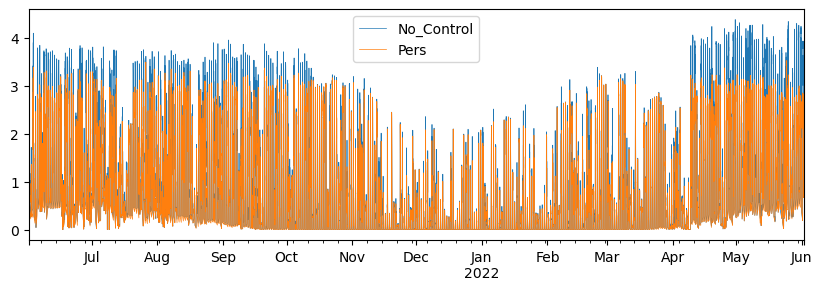

In [200]:
ctrld_HvProd_concat_df.plot(figsize=(10,3), lw=0.5)

#### Compute Energy


In [201]:
# Compute Energy
var_no_control, var_Persistence = ctrld_HvProd_concat_df.sum()*Δt

print(f'{ctrld_HvProd_name} prod,   No Control  : {var_no_control:.2f} MWh')
print(f'{ctrld_HvProd_name} prod, Future known  : {var_Persistence:.2f} MWh |  Perc = {var_Persistence*100/var_no_control:.2f}%')


P0100 prod,   No Control  : 5229.63 MWh
P0100 prod, Future known  : 4493.00 MWh |  Perc = 85.91%


##### Save Variables
*<span style='color:green'>Run the following cell only one </span>*

In [ ]:
var_to_save = dict({f'{ctrld_HvProd_name}_concat_df':ctrld_HvProd_concat_df,
                    'voltage_rise_df':max_vm_pu_per_df, 
                    'Out_blocProd': extracted_results.loc[per_index2]# Where out bloc prod is the result 
                                                        # of the prediction using the persistence model 
                                                        # and the corresponding OPF voltage rise
                   })

joblib.dump(var_to_save,f'{simResult_folder}Persistence.pkl')
